In [65]:
""" (BIR-VAE)
Bounded Information Rate Variational Autoencoder

http://www.kdd.org/kdd2018/files/deep-learning-day/DLDay18_paper_31.pdf


This VAE variant makes a slight change to the original formulation
in an effort to enforce mutual information between our inputs x and the
latent space z. The change is setting the variance of q(z|x) instead of
learning it, which allows us to control the information rate across the
channel (Eqn. 7). It also implicity maximizes mutual information between
x and z without direct computation subject to the constraint q(z)=N(0,I).
This happens when the Maximum Mean Discrepancy between q(z) and p(z) is
0, and causes the mutual information term to reduce to a constant because
the differential entropy between h_q(z)[z] and h_q(z|x)[z] are both fixed
(Eqn. 10/11). The output of the decode is the mean of the isotropic
Gaussian with variance 1, so the log likelihood reduced to the negative
mean square error (i.e. we use MSELoss instead of NLLLoss).

"""
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
from itertools import product

from src.utils import *


class Encoder(nn.Module):
    """ MLP encoder for VAE. Input is an image,
    outputs is the mean and std of the latent representation z pre-reparametrization
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()

        self.linear = nn.Linear(image_size, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        activated = F.relu(self.linear(x)) 
        mu = self.mu(activated)
        return mu


class Decoder(nn.Module):
    """ MLP decoder for VAE. Input is a reparametrized latent representation,
    output is reconstructed image """
    def __init__(self, z_dim, hidden_dim, image_size):
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.recon = nn.Linear(hidden_dim, image_size)

    def forward(self, z):
        activated = F.relu(self.linear(z))
        reconstructed = torch.sigmoid(self.recon(activated))
        return reconstructed


class BIRVAE(nn.Module):
    """ VAE super class to reconstruct an image. Contains reparametrization method
    Parameter I indicates how many bits should be let through.
    """
    def __init__(self, image_size=784, hidden_dim=400, z_dim=20, I=13.3):
        super().__init__()

        self.__dict__.update(locals())

        self.encoder = Encoder(image_size=image_size, hidden_dim=hidden_dim, z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim, hidden_dim=hidden_dim, image_size=image_size)
        
        self.set_var = 1/(4**(I/z_dim))

    def forward(self, x):
        mu = self.encoder(x)
        z = self.reparameterize(mu)
        out_img = self.decoder(z)
        return out_img, mu, z

    def reparameterize(self, mu):
        """" Reparametrization trick: z = mean + epsilon, where epsilon ~ N(0, set_var)."""
        y = to_cuda(torch.from_numpy(np.random.normal(loc=0.0, scale=self.set_var, size=mu.shape)).float())
        z = mu + y
        return z


class BIRVAETrainer:
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        """ Object to hold data iterators, train the model """
        self.model = to_cuda(model)
        self.name = model.__class__.__name__

        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter

        self.best_val_loss = 1e10
        self.debugging_image, _ = next(iter(test_iter))
        self.viz = viz

    def train(self, num_epochs, lr=1e-3, weight_decay=1e-5, LAMBDA=1000):
        """ Train a Variational Autoencoder
            Logs progress using total loss, reconstruction loss, maximum mean
            discrepancy (MMD), and validation loss

        Inputs:
            num_epochs: int, number of epochs to train for
            lr: float, learning rate for Adam optimizer (default 1e-3)
            weight_decay: float, weight decay for Adam optimizer (default 1e-5)
            LAMBDA: float, weight of MMD term relative to mse_loss (default 1000)
        """

        # Adam optimizer, sigmoid cross entropy for reconstructing binary MNIST
        optimizer = optim.Adam(params=[p for p in self.model.parameters() if p.requires_grad], 
                               lr=lr, 
                               weight_decay=weight_decay)

        # Begin training
        for epoch in tqdm(range(1, num_epochs+1)):

            self.model.train()
            epoch_loss, epoch_recon, epoch_mmd = [], [], []

            for batch in self.train_iter:

                # Zero out gradients
                optimizer.zero_grad()

                # Compute mean squared error loss, mean maximum discrepancy loss
                mse_loss, mmd_loss = self.compute_batch(batch)
                batch_loss = mse_loss + LAMBDA*mmd_loss

                # Update parameters
                batch_loss.backward()
                optimizer.step()

                # Log metrics
                epoch_loss.append(batch_loss.item())
                epoch_recon.append(mse_loss.item())
                epoch_mmd.append(mmd_loss.item())

            # Test the model on the validation set
            self.model.eval()
            val_loss = self.evaluate(self.val_iter)

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_model = deepcopy(self.model)
                self.best_val_loss = val_loss

            # Progress logging
            print ("Epoch[%d/%d], Total Loss: %.4f, MSE Loss: %.4f, MMD Loss: %.4f, Val Loss: %.4f"
                   %(epoch, num_epochs, np.mean(epoch_loss), np.mean(epoch_recon), np.mean(epoch_mmd), val_loss))

            # Debugging and visualization purposes
            if self.viz:
                self.reconstruct_images(self.debugging_image, epoch)
                plt.show()

    def compute_batch(self, batch):
        """ Compute loss for a batch of examples """

        # Reshape images
        images, _ = batch
        images = to_cuda(images.view(images.shape[0], -1))

        # Get output images, mean, std of encoded space
        output, mu, z = self.model(images)

        # Mean squared error loss
        mse_loss = torch.sum((images - output) ** 2)
        
        # Maximum mean discrepancy
        mmd_loss = self.maximum_mean_discrepancy(mse_loss)

        return mse_loss, mmd_loss
    
    def maximum_mean_discrepancy(self, mse_loss):
        """ Maximum mean discrepancy of a Gaussian kernel (Eqn. 13) """
        return torch.exp(-(mse_loss/2*self.model.z_dim))

    def evaluate(self, iterator):
        """ Evaluate on a given dataset """
        loss = []
        for batch in iterator:
            mse_loss, mmd_loss = self.compute_batch(batch)
            batch_loss = mse_loss + mmd_loss
            loss.append(batch_loss.item())

        loss = np.mean(loss)
        return loss

    def reconstruct_images(self, images, epoch, save=True):
        """Reconstruct a fixed input at each epoch for progress visualization """
        # Reshape images, pass through model, reshape reconstructed output
        batch = to_cuda(images.view(images.shape[0], -1))
        reconst_images, _, _ = self.model(batch)
        reconst_images = reconst_images.view(images.shape).squeeze()

        # Plot
        plt.close()
        size_figure_grid, k = int(reconst_images.shape[0]**0.5), 0
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(reconst_images[k].data.numpy(), cmap='gray')
            k += 1

        # Save
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.data,
                                         outname + 'real.png',
                                         nrow=size_figure_grid)
            torchvision.utils.save_image(reconst_images.unsqueeze(1).data,
                                         outname + 'reconst_%d.png' %(epoch),
                                         nrow=size_figure_grid)

    def sample_images(self, num_images=64):
        """ Viz method 1: generate images by sampling z ~ p(z), x ~ p(x|z,θ) """
        
        # Sample from latent space randomly, visualize output
        sample = to_cuda(torch.randn(num_images, self.model.decoder.linear.in_features))
        sample = self.model.decoder(sample)
        to_img = ToPILImage()
        img = to_img(make_grid(sample.data.view(num_images, 1, 28, 28)))
        display(img)

    def sample_interpolated_images(self):
        """ Viz method 2: sample two random latent vectors from p(z),
        then sample from their interpolated values """
        
        # Sample latent vectors
        z1 = torch.normal(torch.zeros(self.model.decoder.linear.in_features), 1)
        z2 = torch.normal(torch.zeros(self.model.decoder.linear.in_features), 1)
        to_img = ToPILImage()

        # Interpolate within latent vectors
        for alpha in np.linspace(0, 1, self.model.decoder.linear.in_features):
            z = to_cuda(alpha*z1 + (1-alpha)*z2)
            sample = self.model.decoder(z)
            display(to_img(make_grid(sample.data.view(28, 28).unsqueeze(0))))

    def explore_latent_space(self, num_epochs=3):
        """ Viz method 3: train a VAE with 2 latent variables, compare variational means """

        # Initialize and train a VAE with size two dimension latent space
        train_iter, val_iter, test_iter = get_data()
        latent_model = VAE(image_size=784, hidden_dim=400, z_dim=2)
        latent_space = VAETrainer(latent_model, train_iter, val_iter, test_iter)
        latent_space.train(num_epochs)
        latent_model = latent_space.best_model

        # Across batches in train iter, collect variationa means
        data = []
        for batch in train_iter:
            images, labels = batch
            images = to_cuda(images.view(images.shape[0], -1))
            mu, log_var = latent_model.encoder(images)

            for label, (m1, m2) in zip(labels, mu):
                data.append((label.item(), m1.item(), m2.item()))

        # Plot
        labels, m1s, m2s = zip(*data)
        plt.figure(figsize=(10,10))
        plt.scatter(m1s, m2s, c=labels)
        plt.legend([str(i) for i in set(labels)])

        # Evenly sample across latent space, visualize the outputs
        mu = torch.stack([torch.FloatTensor([m1, m2])
                          for m1 in np.linspace(-2, 2, 10)
                          for m2 in np.linspace(-2, 2, 10)])
        samples = latent_model.decoder(to_cuda(mu))
        to_img = ToPILImage()
        display(to_img(make_grid(samples.data.view(-1, 1, 28, 28), nrow=10)))

        return latent_model

    def make_all(self):
        """ Execute all viz methods outlined in this class """

        print('Sampling images from latent space...')
        self.sample_images()

        print('Interpolating between two randomly sampled...')
        self.sample_interpolated_images()

        print('Exploring latent representations...')
        _ = self.explore_latent_space()
        
    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)

    def load_model(self, loadpath):
        """ Load state dictionary into model. If model not specified, instantiate it """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)




  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], Total Loss: 4357.7227, MSE Loss: 4357.7227, MMD Loss: 0.0000, Val Loss: 2830.8207


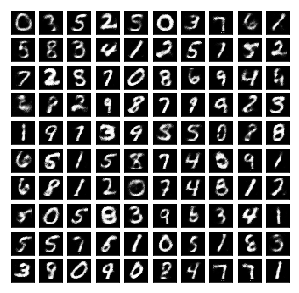




  4%|▍         | 1/25 [00:05<02:16,  5.68s/it]

KeyboardInterrupt: 

In [69]:
# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
# train_iter, val_iter, test_iter = get_data()

# Init model
model = BIRVAE(image_size=784,
               hidden_dim=256,
               z_dim=128,
               I=13.3)

# Init trainer
trainer = BIRVAETrainer(model=model,
                        train_iter=train_iter,
                        val_iter=val_iter,
                        test_iter=test_iter,
                        viz=True)

# Train
trainer.train(num_epochs=25, 
              lr=1e-3,
              weight_decay=1e-5, 
              LAMBDA=1000)